# **Handling Class Imbalance: Oversampling & Undersampling Techniques**  

This notebook explores methods to improve **model performance** when dealing with **imbalanced datasets**.  
We focus on two key techniques:  

- **Oversampling**: Increasing the number of samples in the minority class.  
- **Undersampling**: Reducing the number of samples in the majority class.  

By applying these methods, we aim to **mitigate bias**, enhance model **generalization**, and evaluate their impact on overall performance. This hands-on approach will help in understanding the effectiveness of different resampling techniques in real-world scenarios.  


In [44]:
import pandas as pd
import matplotlib.pyplot as plt


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score


In [45]:
dataset=pd.read_csv('../Data/train.csv')
dataset.head()

,Category,Message
0,ham,Heehee that was so funny tho
1,ham,I don wake since. I checked that stuff and saw...
2,ham,Dai what this da.. Can i send my resume to thi...
3,ham,U too...
4,ham,Didn't you get hep b immunisation in nigeria.


In [46]:
def clean_text(text):
    words_to_remove = set(stopwords.words('english'))
    text = text.lower()
    # Remove punctuation but keep !, $, @, ? since they exist more in spams than hams as in EDA notebook
    text = re.sub(r"[^\w\s!$@?]", "", text)  
    text = nltk.word_tokenize(text)
    text = [word for word in text if word not in words_to_remove]
    text = ' '.join(text)
    return text

In [47]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = nltk.word_tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [48]:
dataset['cleaned_text'] = dataset['Message'].apply(clean_text)
dataset['cleaned_text'] = dataset['cleaned_text'].apply(lemmatize_text)
dataset.head()


,Category,Message,cleaned_text
0,ham,Heehee that was so funny tho,heehee funny tho
1,ham,I don wake since. I checked that stuff and saw...,wake since checked stuff saw true available sp...
2,ham,Dai what this da.. Can i send my resume to thi...,dai da send resume id
3,ham,U too...,u
4,ham,Didn't you get hep b immunisation in nigeria.,didnt get hep b immunisation nigeria


In [49]:
dataset.drop(['Message'], axis=1, inplace=True)

In [50]:
Count_Vectorizer=CountVectorizer()
X_Count=Count_Vectorizer.fit_transform(dataset['cleaned_text'])
X_Count.shape

(5014, 8326)

In [51]:
def showscore(yhat,y_acutal):
    print(f'recall score: {recall_score(y_acutal,yhat)}')
    print(f'precision score: {precision_score(y_acutal,yhat)}')
    print(f'f1 score: {f1_score(y_acutal,yhat)}')
    print(f'confusion_matrix: {confusion_matrix(y_acutal,yhat)}')    

In [52]:
y=dataset['Category'].replace({'ham':0, 'spam':1})

C:\Users\Karim Mahmoud\AppData\Local\Temp\ipykernel_8884\1518397032.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=dataset['Category'].replace({'ham':0, 'spam':1})


In [53]:
y.value_counts()

Category
0    4342
1     672
Name: count, dtype: int64

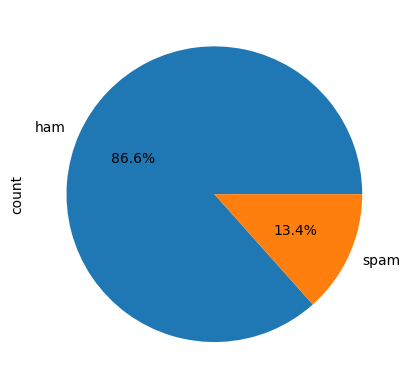

In [54]:
fig, ax = plt.subplots()
dataset['Category'].value_counts().plot(ax=ax, kind='pie', autopct='%1.1f%%')
plt.show()

In [55]:
X_train_Count, X_cv_Count, y_train_Count, y_cv_Count =  train_test_split(X_Count, y, test_size=0.1,stratify=y, random_state=42)

In [56]:
smote = SMOTE(sampling_strategy='minority')
X_train_count_res, y_train_count_res = smote.fit_resample(X_train_Count, y_train_Count)

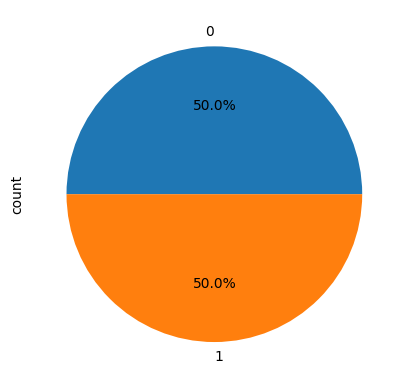

In [57]:
fig, ax = plt.subplots()
y_train_count_res.value_counts().plot(ax=ax, kind='pie', autopct='%1.1f%%')
plt.show()

In [58]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_count_res, y_train_count_res)
y_pred = svm.predict(X_cv_Count)
showscore(y_cv_Count, y_pred)

recall score: 0.6056338028169014
precision score: 0.6417910447761194
f1 score: 0.6231884057971014
confusion_matrix: [[407  24]
 [ 28  43]]


In [59]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_count_res, y_train_count_res)
y_pred = naive_bayes.predict(X_cv_Count)
showscore(y_cv_Count, y_pred)

recall score: 0.8955223880597015
precision score: 0.8955223880597015
f1 score: 0.8955223880597015
confusion_matrix: [[428   7]
 [  7  60]]


In [60]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train_count_res, y_train_count_res)
y_pred = model.predict(X_cv_Count)
showscore(y_cv_Count, y_pred)

recall score: 0.9285714285714286
precision score: 0.7761194029850746
f1 score: 0.8455284552845529
confusion_matrix: [[431  15]
 [  4  52]]


## Observations on SMOTE Performance

It appears that applying SMOTE did not improve performance by oversampling the minority class. This could be due to several factors, such as:

- The presence of noisy data.
- Class overlap, where synthetic samples are generated too close to other classes, leading to misclassification.

To address this, we can apply Tomek Links after oversampling. This will help by removing synthetic samples that are too close to a different class, potentially improving model performance. Let's proceed with this approach.


In [66]:
tl=TomekLinks()
X_train_count_res_cleaned, y_train_count_res_cleaned = tl.fit_resample(X_train_count_res, y_train_count_res)

In [67]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_count_res_cleaned, y_train_count_res_cleaned)
y_pred = svm.predict(X_cv_Count)
showscore(y_cv_Count, y_pred)

recall score: 0.6056338028169014
precision score: 0.6417910447761194
f1 score: 0.6231884057971014
confusion_matrix: [[407  24]
 [ 28  43]]


In [68]:
nb=MultinomialNB()
nb.fit(X_train_count_res_cleaned, y_train_count_res_cleaned)
y_pred = nb.predict(X_cv_Count)
showscore(y_cv_Count, y_pred)

recall score: 0.8955223880597015
precision score: 0.8955223880597015
f1 score: 0.8955223880597015
confusion_matrix: [[428   7]
 [  7  60]]


In [69]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_count_res_cleaned, y_train_count_res_cleaned)
y_pred = xgb_model.predict(X_cv_Count)
showscore(y_cv_Count, y_pred)

recall score: 0.9285714285714286
precision score: 0.7761194029850746
f1 score: 0.8455284552845529
confusion_matrix: [[431  15]
 [  4  52]]


## Conclusion

It looks like these methods (SMOTE and Tomek Links) did not improve the model performance. Therefore, we can stick to regular models that handle data imbalance directly, as they may be more suitable for this particular dataset.
